In [95]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/linear/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/02_train_linear.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['r2_gap'] = r['r2_train'] - r['r2_test']
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 105/105 [00:00<00:00, 3274.05it/s]


### Look at pred performance

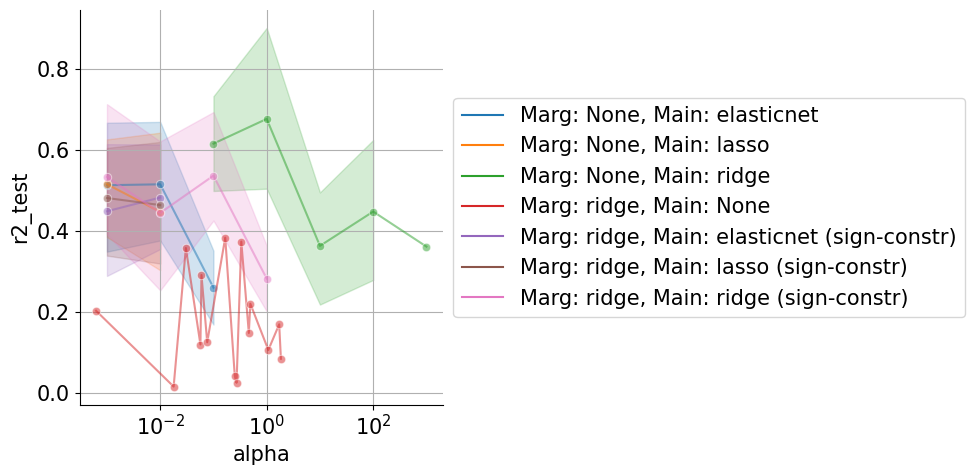

In [96]:
d = r
for k in ["seed"]: #, "dataset_name"]:
    d = imodelsx.process_results.average_over_seeds(
        d, experiment_filename, key_to_average_over=k
    )

d["legend"] = (
    "Marg: "
    + d["est_marginal_name"]
    + d["use_marginal_divide_by_d"].map({0: "(no div) ", 1: ""})
    + ", "
    + "Main: "
    + d["est_main_name"]
    + d['use_marginal_sign_constraint'].map({0: "", 1: " (sign-constr)"})
)

# d = d[d.legend.str.contains('Main: ridge', case=False)]

fig, ax = plt.subplots(figsize=(10, 5))
# x = 'collinearity_factor' # 'train_frac', 'y_train_noise_std', 'collinearity_factor'
# x = 'train_frac'
x = "alpha"
# sns.lineplot(data=r, x="train_frac", y="r2_test", hue="legend", markers=True)
sns.lineplot(
    data=d, x=x, y="r2_test", hue="legend", markers=True, marker="o", alpha=0.5
)
plt.xscale("log")
plt.grid()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.yscale("log")
plt.show()

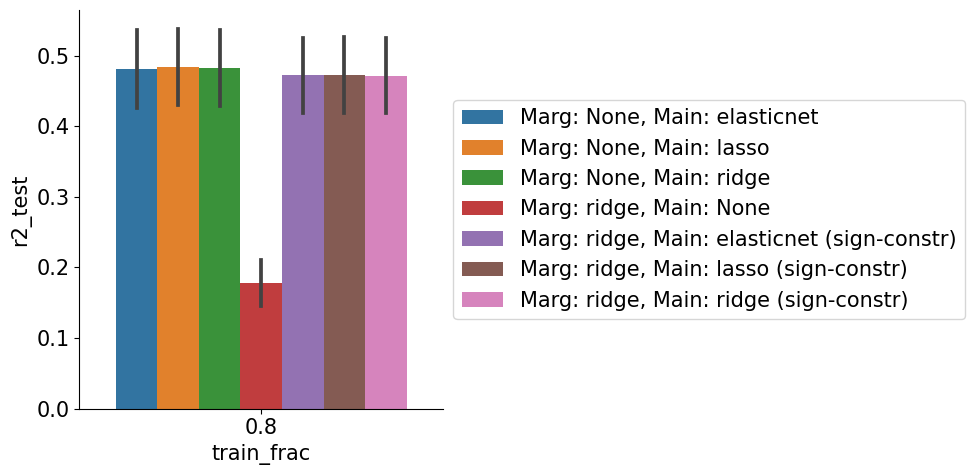

In [100]:
d2 = d
# d2 = d2[r.train_frac >= 0.8]
# d2 = d2[d.r2_test >= 0.3]
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=d2, x="train_frac", y="r2_test", hue="legend", errorbar='se')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

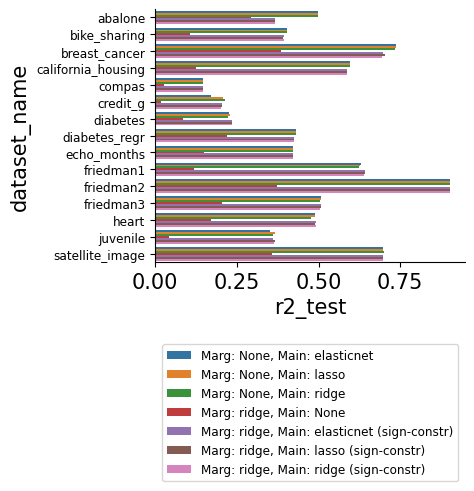

In [143]:
# d = r[r.train_frac >= 0.8]
# d = r[r.train_frac <= 0.3]
# d = d[d.r2_test >= 0.3]
# d2 = d[d.legend.str.contains('lasso', case=False)]
# fig, ax = plt.subplots(figsize=(10, 10)) #figsize=(10, 5))
fig, ax = plt.subplots(figsize=(5, 5)) #figsize=(10, 5))
sns.barplot(data=d2, y= "dataset_name", x="r2_test", hue="legend")
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='xx-small')
# place legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fontsize='xx-small',)
# set yticks fontsize small
plt.yticks(fontsize='xx-small')
plt.tight_layout()
plt.show()

### Analyze coefs between different runs

In [101]:
imodelsx.process_results.get_experiment_keys(r, experiment_filename)

['dataset_name',
 'est_marginal_name',
 'est_main_name',
 'use_marginal_sign_constraint',
 'alpha']

In [133]:
d = r
d = d[d.seed == 1]
d = d[d.use_marginal_divide_by_d == 1]
d = d[d.collinearity_factor == 0.0]

df = defaultdict(list)
models = ["ridge", "lasso", "elasticnet"]
for model in models:
    df_model = defaultdict(list)
    for idx, g in d.groupby(
        [
            "dataset_name",
            # "est_marginal_name",
            # "est_main_name",
        ]
    ):
        coef_marg = g[
            (g.est_marginal_name == "ridge") & (g.est_main_name == "None")
        ].coef.values[0]
        coef_baseline = g[
            (g.est_marginal_name == "None") & (g.est_main_name == model)
        ].coef.values[0]
        coef_shrinkage = g[
            (g.est_marginal_name == "ridge") & (g.est_main_name == model)
        ].coef.values[0]

        df_model["dataset_name"].append(idx[0])

        def sign_match(x, y):
            return np.mean(
                (np.sign(x) == np.sign(y)) | (np.sign(x) == 0) | (np.sign(y) == 0)
            )

        df_model["sign_flip_frac_baseline"].append(1 - sign_match(coef_marg, coef_baseline))
        # df_model["sign_agreement_shrinkage"].append(sign_match(coef_marg, coef_shrinkage))
        df_model['flipped_values_baseline'].append(coef_baseline[np.sign(coef_marg) != np.sign(coef_baseline)])
        # print(coef_marg, coef_main)
        # break
    df['d_sign'].append(pd.DataFrame(df_model).round(2))
    df['model'].append(model)
    # display(d_sign)

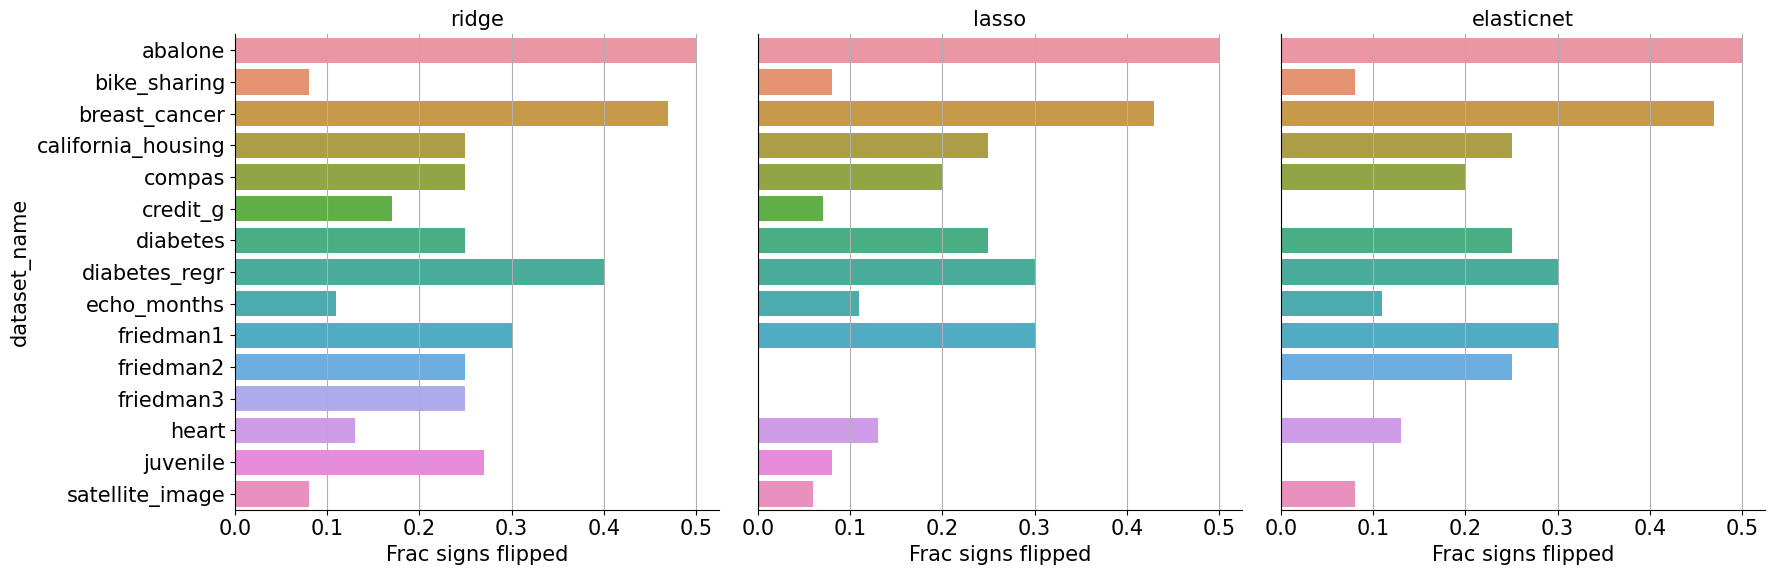

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, model in enumerate(models):
    d_sign = df['d_sign'][i]
    ax = axes[i]
    sns.barplot(y='dataset_name', x='sign_flip_frac_baseline', data=d_sign, ax=ax)
    ax.set_xlabel('Frac signs flipped')
    if i > 0:
        ax.set_ylabel('')
        # hide y ticks
        ax.set_yticks([])
    ax.set_title(model, fontsize='medium')
    ax.grid(axis='x')
    plt.tight_layout()
plt.show()

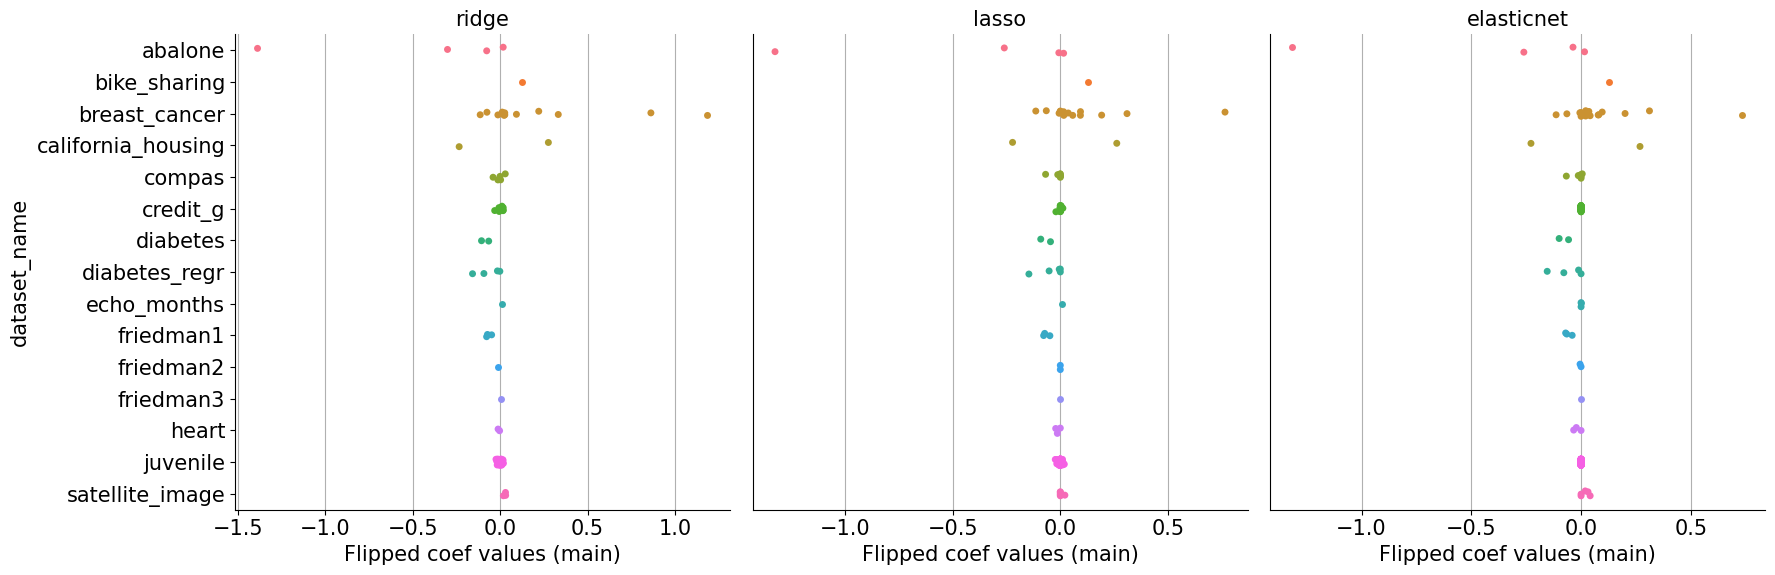

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, model in enumerate(models):
    d_sign = df['d_sign'][i].explode(column='flipped_values_baseline')
    ax = axes[i]
    sns.stripplot(y='dataset_name', x='flipped_values_baseline', data=d_sign, ax=ax, hue='dataset_name', legend=False)
    ax.set_xlabel('Flipped coef values (main)')
    if i > 0:
        ax.set_ylabel('')
        # hide y ticks
        ax.set_yticks([])
    ax.set_title(model, fontsize='medium')
    ax.grid(axis='x')
    plt.tight_layout()
plt.show()